In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

import TOFPET_cal_lib as TPcal
import TOFPET_ToT_lib as tot
from scipy import interpolate
import time
import build_data_df_mine as bd
from functools import partial
import multiprocessing as mp

%matplotlib nbagg
%load_ext autoreload
%autoreload 2

In [2]:
def shaped_spe(time, tau_sipm):
    alfa      = 1.0/tau_sipm[1]
    beta      = 1.0/tau_sipm[0]
    t_p       = np.log(beta/alfa)/(beta-alfa)
    K         = (beta)*np.exp(alfa*t_p)/(beta-alfa)
    time_dist = K*(np.exp(-alfa*time)-np.exp(-beta*time))
    return time_dist

def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def triangle(x,mu,length):
    A = np.arange(2/length,1+2/length,2/length)
    B = np.arange(1-2/length,0,-2/length)
    A_len = len(A)
    B_len = len(B)
    center = np.argwhere(x==mu)[0][0]
    print(center)
    pre_A = np.zeros(center-A_len)
    post_B = np.zeros(len(x)-(center+B_len))
    return np.concatenate((pre_A,A,B,post_B))

def semigaussian(time,BW, pes, f_sample=1E9,target_q=1.28E-12):
    #RC2 Semigaussian pulse
    RC=1/(BW*2*np.pi)
    freq_RCd = 1/(RC*f_sample*np.pi) 
    bsl1, asl1 = signal.butter(1, freq_RCd, 'low', analog=False);
    BS = bsl1
    AS = asl1
    #BS = np.convolve(bsl1,bsl1)
    #AS = np.convolve(asl1,asl1)
    #BS = np.convolve(BS,bsl1)
    #AS = np.convolve(AS,asl1)
    
    spe_wave_pure   = shaped_spe(time,[1,40])
    spe_wave_q_norm = spe_wave_pure/(np.sum(spe_wave_pure)*(1.0/f_sample))
    spe_wave        = pes * target_q * spe_wave_q_norm
        
    signal_out = signal.lfilter(BS,AS,spe_wave)  
    
    return signal_out


In [3]:
def ToT(time,wave,T1,T2):
    
    cross_T2_1 = np.min(time[wave >= T2])
    cross_T2_2 = np.max(time[wave >= T2])
    cross_T2_1_arg = np.argwhere(time == cross_T2_1)[0][0]
    cross_T2_2_arg = np.argwhere(time == cross_T2_2)[0][0]

    cross_T1_1 = np.min(time[wave >= T1])
    cross_T1_2 = np.max(time[wave >= T1])
    cross_T1_1_arg = np.argwhere(time == cross_T1_1)[0][0]
    cross_T1_2_arg = np.argwhere(time == cross_T1_2)[0][0]
    
    ToT_T2    = cross_T2_2 - cross_T2_1
    ToT_T2_T1 = cross_T1_2 - cross_T2_1
    
    Q_ToT_T2    = np.sum(wave[cross_T2_1_arg:cross_T2_2_arg])
    Q_ToT_T2_T1 = np.sum(wave[cross_T2_1_arg:cross_T1_2_arg])
        
    return ToT_T2, ToT_T2_T1, Q_ToT_T2, Q_ToT_T2_T1

##### [run: 11293]
### Datasheet says Zin = 15 Ohms
### Cpar = 1.2 nF --> BW = 8.8 Mhz (PD is external so Z is constant till BW)
### Input Amplifier GAIN = 3000 (Saturates at 0.9V)
### SENSOR_ID = 44
### Vth_T2 (LSB=55) MAX = 0.9 
### VTH_T2 = 36 (0.72V) // Vbaseline = 30 (0.68V)
### RUN:11293 Vth_T2 = 26 (0.78V) --> 0.78 - 0.68 = 100 mV T2
### pe_peak = 23.78 uA 

<IPython.core.display.Javascript object>


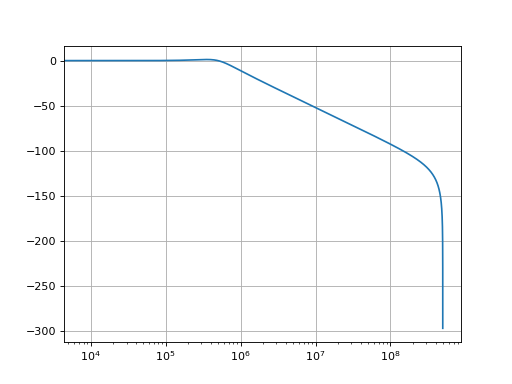

In [247]:
plt.figure()
fs = 1E9

b,a = signal.bilinear([(500E3*2*np.pi)**2], [1,2*0.5*500E3*2*np.pi,(500E3*2*np.pi)**2], fs)

wz, hz = signal.freqz(b, a,worN=2**16)

plt.semilogx(wz*(fs)/(2*np.pi), 20 * np.log10(abs(hz)))

plt.grid()

<IPython.core.display.Javascript object>


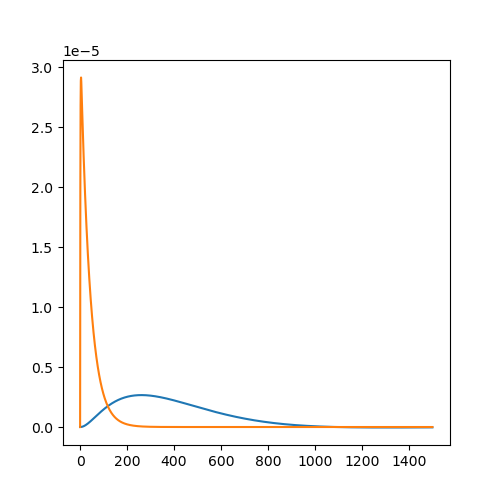

SiPM Output Peak   = 29.155827 uA (1.000000 pe)
Inside TOFPET Peak = 2.662725 uA (1.000000 pe)
Effective T2       = 200.000000 mV (25.037011 pe) (66.666667 uA)


In [257]:
BW = 800E3 #1/(15*1200E-12*6.28)
Gain = 3000
target_q_VOV_8 = 1.28E-12
T2_eff = 200E-3 #= 180E-3

T_sample = 1E-9
time = np.arange(0,1500,1)

spe_wave_pure   = shaped_spe(time,[1,40])
spe_wave_q_norm = spe_wave_pure/(np.sum(spe_wave_pure)*(T_sample))

wave_1 = tot.channel_shp_2nd_spe(time,f0=BW,rho=0.8,pes=1) #semigaussian(time,BW,1)
T2_pe  = (T2_eff/Gain)/(np.max(wave_1))

plt.figure(figsize=(5,5))
plt.plot(time,wave_1)
plt.plot(time,spe_wave_q_norm*target_q_VOV_8)
print("SiPM Output Peak   = %f uA (%f pe)" % (np.max(spe_wave_q_norm*target_q_VOV_8)*1E6,1))
print("Inside TOFPET Peak = %f uA (%f pe)" % (np.max(wave_1)*1E6,1))
print("Effective T2       = %f mV (%f pe) (%f uA)" % (T2_eff*1E3,T2_pe,1E6*T2_eff/Gain))

pe_peak_sipm   = np.max(spe_wave_q_norm*target_q_VOV_8)
pe_peak_tofpet = np.max(wave_1)

In [5]:
np.sum(wave_1)*1E-9

1.2757741253003694e-12

# SPE RESPONSE with FITTING of ToT_to_PE function

table_time_spe = np.arange(0,1500,1)
table_spe_df = np.concatenate((table_time_spe.reshape(-1,1),wave_1.reshape(-1,1)),axis=1)
path_out                = "/home/vherrero/CALIBRATION_FILES/"
filename_spe_response   = "spe_response_TOFPET_11.h5"
table_spe_df            = pd.DataFrame(table_spe_df,columns=['time_ns','value'])
storage = pd.HDFStore(path_out + filename_spe_response,'w',complib="zlib",complevel=4)
storage.put('response',table_spe_df,index=False,format='table',data_columns=True)
storage.close()

<IPython.core.display.Javascript object>


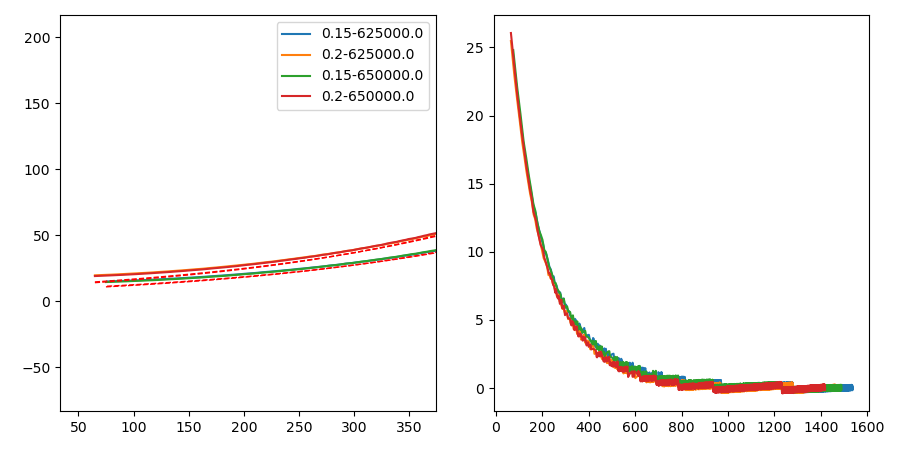

Coeffs = [  8.49046438 255.12759978] // chi2_r = 0.006092829171718371
Coeffs = [ 11.40079844 255.47408747] // chi2_r = 0.007235780492139688
Coeffs = [  8.1003549  245.29443297] // chi2_r = 0.006439011908939654
Coeffs = [ 10.87773157 245.62798084] // chi2_r = 0.007641974758476466


In [198]:
# OK: T2=1 // BW=1.25MHz [min_pe = 7]
# OK: T2=3 // BW=1.25MHz [min_pe = 22] "ToT_PE_conversion5_T2_3.h5" (400ns -> 55 pe)


Gain = 3000
target_q_VOV_8 = 1.28E-12
time = np.arange(0,10000,1)
T_sample = 1E-9
spe_wave_pure   = shaped_spe(time,[1,40])
spe_wave_q_norm = spe_wave_pure/(np.sum(spe_wave_pure)*(T_sample))



fig, axis = plt.subplots(1,2,figsize=(9,4.5))


for BW in [625E3,650E3]:
    for T2_eff in [150E-3,200E-3]:

        wave_1 = semigaussian(time,BW,1)
        pe_peak_tofpet = np.max(wave_1)
        T2_pe  = (T2_eff/Gain)/pe_peak_tofpet

        pe_peak_sipm   = np.max(spe_wave_q_norm*target_q_VOV_8)

        A_range  = np.arange(T2_pe+1,3500,0.5)

        ToT_T2 = []
        ToT_T2_T1 = []
        Q_ToT_T2 = []
        Q_ToT_T2_T1 = []

        for A in A_range:
            wave=semigaussian(time,BW,A)
            aux1,aux2,aux3,aux4 = ToT(time,wave,
                                      T1=pe_peak_tofpet*0.25,
                                      T2=T2_eff/Gain)
            ToT_T2.append(aux1)
            ToT_T2_T1.append(aux2)
            Q_ToT_T2.append(A)
            Q_ToT_T2_T1.append(A)

        axis[0].plot(ToT_T2,   A_range, label=str(T2_eff)+"-"+str(BW))
        #axis[1].plot(A_range, ToT_T2,  label=str(T2_eff)+"-"+str(BW))
        #axis[1].legend()

        axis[0].set_title("Charge vs ToT")
        #axis[1].set_title("ToT vs pe (T2_T1)")
        axis[0].set_xlabel('ToT (ns)')
        axis[0].set_ylabel('Signal Integral (pe)')
        #axis[1].set_xlabel('pe')
        #axis[1].set_ylabel('ToT - T2 (ns)')
        
        #axis[0].plot(tabla_disco['ToT_ns'],tabla_disco['pe'],'r')
        weights = np.ones(len(ToT_T2))
        weights_argw = np.argwhere(np.array(ToT_T2) < 200).reshape(-1)
        weights[weights_argw] = np.ones(len(weights_argw))
        
        tot2pe = tot.fit_fun(A_range,np.array(ToT_T2),
                             fit_func = tot.exp_pure,
                             # param[0] + param[1]*np.exp((x-param[2])/param[3])
                             guess = [10,255],
                             fit_method = 'trf',
                             bounds = [[0,      150],
                                       [np.inf, 300]],
                             #sigma = weights
                            )
        tot2pe.show_data(axis[0])
        print("Coeffs =",tot2pe.coeff,"// chi2_r =",tot2pe.chisq_r)
        axis[1].plot(ToT_T2,(100*np.array(A_range-tot2pe.evaluate())/A_range))
        
        axis[0].legend()

        plt.tight_layout()

ToT_T2   = np.array(ToT_T2)
Q_ToT_T2 = np.array(Q_ToT_T2)

#print(A_range[np.argwhere(ToT_T2==500)[0][0]])
#print(A_range[np.argwhere(ToT_T2==1000)[0][0]])

# PE -> ToT (For MC simulation)

In [159]:
res=interpolate.interp1d(Q_ToT_T2,ToT_T2)
mini = np.min(Q_ToT_T2)
maxi = np.max(Q_ToT_T2)
table = res(np.arange(mini,maxi,0.1))
table_df = np.concatenate((np.arange(mini,maxi,0.1).reshape(-1,1),table.reshape(-1,1)),axis=1)

In [160]:
table_df

array([[  19.7268332,   65.       ],
       [  19.8268332,   69.       ],
       [  19.9268332,   72.       ],
       ...,
       [3499.7268332, 1463.       ],
       [3499.8268332, 1463.       ],
       [3499.9268332, 1463.       ]])

In [161]:
path_out             = "/home/vherrero/CALIBRATION_FILES/"
filename_ToT_table   = "PE_ToT_conversion12d_high.h5"
table_df = pd.DataFrame(table_df,columns=['pe','ToT_ns'])
storage = pd.HDFStore(path_out + filename_ToT_table,'w',complib="zlib",complevel=4)
storage.put('ToT_T2_T1',table_df,index=False,format='table',data_columns=True)
storage.close()

# ToT -> PE (For data processing)

In [162]:
#mini = 124
#maxi = 700
mini = np.min(ToT_T2)
maxi = np.max(ToT_T2)
res2=interpolate.interp1d(ToT_T2,Q_ToT_T2)
table2 = res2(range(mini,maxi,1))
table_df2=np.concatenate((np.arange(mini,maxi,1).reshape(-1,1),table2.reshape(-1,1)),axis=1)

In [163]:
path_out             = "/home/vherrero/CALIBRATION_FILES/"
filename_ToT_table   = "ToT_PE_conversion12d_high.h5"
table_df2 = pd.DataFrame(table_df2,columns=['ToT_ns','pe'])
storage = pd.HDFStore(path_out + filename_ToT_table,'w',complib="zlib",complevel=4)
storage.put('ToT_T2',table_df2,index=False,format='table',data_columns=True)
storage.put('params',pd.DataFrame([200,625]))
storage.close()

In [164]:
table_df2[:]

,ToT_ns,pe
0,65.0,19.726833
1,66.0,19.751833
2,67.0,19.776833
3,68.0,19.801833
4,69.0,19.826833
...,...,...
1393,1458.0,3426.626833
1394,1459.0,3440.126833
1395,1460.0,3453.626833
1396,1461.0,3467.226833


In [173]:
tabla_disco=pd.read_hdf("/home/vherrero/CALIBRATION_FILES/ToT_PE_conversion12d_high.h5",key='ToT_T2')

In [174]:
tabla_disco

,ToT_ns,pe
0,65.0,19.726833
1,66.0,19.751833
2,67.0,19.776833
3,68.0,19.801833
4,69.0,19.826833
...,...,...
1393,1458.0,3426.626833
1394,1459.0,3440.126833
1395,1460.0,3453.626833
1396,1461.0,3467.226833


<IPython.core.display.Javascript object>


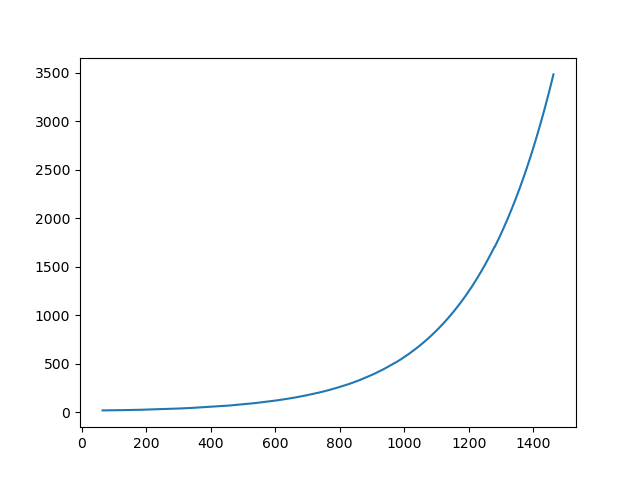

In [175]:
plt.figure()
plt.plot(tabla_disco['ToT_ns'],tabla_disco['pe'])